Experiments on Gridword

#Definition of the environment

In [ ]:
import numpy as np
import scipy
from scipy import stats
import sys
import time
import matplotlib.pyplot as plt
import pdb
 
class GridWorldWithPits():
    def __init__(self, P, R, H = 10, init_state = 0, randomized = False):
        self.R = R
        self.P = P
        self.H = H
        self.randomized = randomized
        self.init_state = init_state
        self.state_memory = []
        self.reset()
 
    def reward_func(self, state, action):
        return self.R[state, action]
 
    def reset(self, s=None):
        self.state = self.init_state
        if self.randomized == True:
            self.state = np.random.randint(0,np.shape(self.P)[0])
        self.state_memory.append(self.state)
        self.t = 0
 
    def step(self, policy):
        action = np.random.choice(np.arange(5), p = policy.eval(self.state)).item()
        reward = self.R[self.state, action]
        self.state = self.P[self.state, action]
        self.t +=1
        if self.t == self.H: 
            done = True
        else: done = False
        return reward, done

Fill the data of the environment: 4x3 gridword experiment.
actions indices: [UP,RIGHT, DOWN, LEFT, STAY] match [0,1,2,3,0] \\
states indices: \\
[8, 9,10,11] \\
[4, 5, 6, 7] \\
[0, 1, 2, 3] \\
word configuration: \\
[o,o,o,g] \\
[o,x,o,o] \\
[s,o,o,o]


In [ ]:
#define deterministic transitions
P = np.array([[4,1,0,0,0],
     [5,2,1,0,1],
     [6,3,2,1,2],
     [7,3,3,2,3],
     [8,5,0,4,4],
     [9,6,1,4,5],
     [10,7,2,5,6],
     [11,7,3,6,7],
     [8,9,4,8,8],
     [9,10,5,8,9],
     [10,11,6,9,10],
     [11,11,7,10,11]])

#define rewards
R = -0.1*np.ones((12,5))
R[7,0] = 0.5
R[10,1] = 0.5
R[11,4] = 0.5
R[1,0] = -1
R[4,1] = -1
R[9,2] = -1
R[6,3] = -1
R[5,4] = -1

Define classes for arm, policy and baseline policy.

In [ ]:
#arm
class Policy:
    def __init__(self, parameters):
        self.parameters = parameters
        self.pp = np.array(
                            [[0,1,0,0,0],
                            [0,1,0,0,0],
                            [0,1,0,0,0],
                            [1,0,0,0,0],
                            [1,0,0,0,0],
                            [0,1,0,0,0],
                            [1,0,0,0,0],
                            [1,0,0,0,0],
                            [0,1,0,0,0],
                            [0,1,0,0,0],
                            [0,1,0,0,0],
                            [0,0,0,0,1]])
    
    def eval(self, state):
        s = 1 / (1 + np.exp(-self.parameters))
        z = (1-s)/4
        return z + (s-z) * self.pp[state,:]

#random policy
class Arm:
    def __init__(self, env, theta, sigma = 1):
        self.env = env
        self.theta = theta
        self.sigma = sigma
        self.count = 0 #nb of time the arm is pulled
        self.payoffs = [] #list samples
        self.parameters = [] #list of policy parameters drawn

    def draw_policy(self):
        eps = scipy.stats.norm.rvs(loc = self.theta, scale = np.sqrt(self.sigma))
        p = Policy(eps)
        return p

    #get the payoff over 1 episode for a given arm
    def pull(self):
        done, payoff = False, 0
        policy = self.draw_policy()
        while done != True:
            r, done = self.env.step(policy)
            payoff += r
        self.payoffs.append(payoff)
        self.parameters.append(policy.parameters)
        self.count += 1
        self.env.reset()
        return payoff
        
#baseline policy
class Baseline:
    def __init__(self):
        self.pp = np.array(
                            [[0,1,0,0,0],
                            [0,1,0,0,0],
                            [0.5,0.5,0,0,0],
                            [1,0,0,0,0],
                            [0,0,1,0,0],
                            [0,1,0,0,0],
                            [1,0,0,0,0],
                            [0.5,0,0,0.5,0],
                            [0,0,1,0,0],
                            [0,0,0,1,0],
                            [0,0.5,0,0.5,0],
                            [0,0,0,0,1]])
    
    def eval(self, state):
        return self.pp[state,:]


Evaluate the payoff of the different policies

In [ ]:
def evaluate(env, arms, n=1000):
    mus = []
    for arm in arms:
        for k in range(n):
            arm.pull()
        mus.append(np.mean(arm.payoffs))
    return mus

Compute and plot regret

In [ ]:
def plot_regret(ax, trace, mus, **kwargs):
    play = 0
    regret = np.zeros(len(trace))

    for t, e in enumerate(trace):
        if e == -1: 
            play += mu_b
        else:
            play += mus[e]
        regret[t] = (t+1)*mus[-1] - play

    ax.plot(regret, **kwargs)
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulative Regret")
    ax.set_title("Regret")

def plot_constraints(ax, trace, mus, alpha, **kwargs):
    cc = np.zeros(len(trace))
    r = 0
    for t, e in enumerate(trace):
        if e == -1: 
            play = mu_b
        else:
            play = mus[e]
        r += play - (1-alpha)*mu_b
        cc[t] = r
    ax.plot(cc, **kwargs)
    ax.set_xlabel("Time")
    ax.set_ylabel("Conservative Condition")
    ax.set_title("Conservative Condition")

#Conservative-Optimistic & Optimistic algorithm

In [ ]:
#select the best arm
#compute \hat{mu} + c^{+}*beta(x,t)
#and \hat{mu} - c^{-}*beta(x,t)
#return best arm, upper bound, lower bound
def best_arm(arms, delta, norm_inf=5.5):
    K = len(arms)
    mus_hat = np.zeros(K) #10 arms
    ub, lb = np.zeros(K), np.zeros(K)
    divRenyi, beta = np.zeros(K), np.zeros(K)
    N = np.sum([arm.count for arm in arms])        
    for i, p in enumerate(arms):
        mus_hat[i] = trunc_estim(i, arms, delta)
        sum = 0
        if N != 0:
            for j, pp in enumerate(arms):
                sum += (pp.count/N) / np.exp(np.power( (p.theta-pp.theta)/p.sigma, 2 ) )     
        if sum == 0:
            ub[i] = mus_hat[i] + norm_inf
            lb[i] = mus_hat[i] - norm_inf
        else:
            divRenyi[i] = 1 / sum
            beta[i] = np.sqrt(divRenyi[i]*np.log(1/(1-delta))/N)
            ub[i] = np.minimum( mus_hat[i] + norm_inf * (np.sqrt(2)+1/3) * beta[i], norm_inf) #bound ub to norm_inf
            lb[i] = np.maximum( mus_hat[i] - norm_inf * (np.sqrt(2)+4/3) * beta[i], -norm_inf) # bound lb to minus norm_inf

    xt = np.argmax(ub)
    return xt, ub, lb, mus_hat, divRenyi

def trunc_estim(xt, arms, delta):
    mu_bh = 0
    N = np.sum([arm.count for arm in arms])
    
    if N == 0: return 0
    
    #get M_N
    sum = 0
    for arm in arms:
        sum += (arm.count/N) / np.exp(np.power( (arms[xt].theta-arm.theta)/arms[xt].sigma, 2 ) )
    divRenyi = 1 / sum
    MN = np.sqrt( N * divRenyi / np.log(1/(1-delta)) )

    for arm in arms:
        for i in range(arm.count):
            #get p_zik
            p_zik = scipy.stats.norm.pdf(arm.parameters[i], loc = arms[xt].theta, scale = np.sqrt(arms[xt].sigma))
            #get denominator expression
            denom = 0
            for armj in arms:
                denom += armj.count/N * scipy.stats.norm.pdf(arm.parameters[i], loc = armj.theta, scale = np.sqrt(armj.sigma))
            #get mu_bh
            mu_bh += np.minimum(MN, p_zik / denom) * arm.payoffs[i]
    
    return mu_bh / N

#Conservative Optimist algorithm
def Conservative_Optimistic(T, mu_b, arms, alpha = 0.05, delta = 0.05):
    trace = [] #list of policy played at each episode
    debug = {"ub": [], "lb": [], "divs": [], "mus_bh":[]}
    cc_mem = mu_b

    for t in range(1, T+1):
        #conservative condition
        #find best arm
        xt, ubs, lbs, mus_hat, divs = best_arm(arms, delta)
        ub, lb = ubs[xt], lbs[xt]
        debug["ub"].append(ubs)
        debug["lb"].append(lbs)
        debug["divs"].append(divs)
        debug["mus_bh"].append(mus_hat)

        if cc_mem + lb  >= (1-alpha)*t*mu_b:
            #play best arm and update mu_hat
            payoff = arms[xt].pull()
            trace.append(xt)
            cc_mem += lb
            print(t)
            print("pulls nb:", [a.count for a in arms])
            print("mus_hat:", mus_hat)
            print("ubs:", ubs)
            print("lbs:", lbs)
            print("\n")

        else:
            #play baseline
            trace.append(-1)
            cc_mem += mu_b

    print("pulls nb:", [a.count for a in arms])
    print("mus_hat:", mus_hat)
    print("ubs:", ubs)
    print("lbs:", lbs)
    print("\n")
    return trace, debug

#Conservative Optimist algorithm
def Optimistic(T, arms, delta = 0.05):
    trace = [] #list of policy played at each episode
    debug = {"ub": [], "lb": [], "divs": [], "mus_bh":[]}

    for t in range(1, T+1):
        #conservative condition
        #find best arm
        xt, ubs, lbs, mus_hat, divs = best_arm(arms, delta)
        ub, lb = ubs[xt], lbs[xt]
        debug["ub"].append(ubs)
        debug["lb"].append(lbs)
        debug["divs"].append(divs)
        debug["mus_bh"].append(mus_hat)

        #play best arm and update mu_hat
        payoff = arms[xt].pull()
        trace.append(xt)
        
    print("pulls nb:", [a.count for a in arms])
    print("mus_hat:", mus_hat)
    print("ubs:", ubs)
    print("lbs:", lbs)
    print("\n")
    return trace, debug

#Experiment 1: single run

In [ ]:
#experiment setting
np.set_printoptions(precision=2)
env = GridWorldWithPits(P,R)
alpha = 0.1 #conservative factor
delta = 0.05
sigma = 1 #arm variance (=overlap control between arms)
np.random.seed(42)

#build policies
arms = []
for theta in np.arange(-5,5,1):
    arms.append(Arm(env, theta, sigma))
mus = evaluate(env, arms, n=1000)
print("arms average payoff: \n", mus)

mu_b = 1.1024240000000003 #baseline payoff evaluated over 1 000 000 runs

arms average payoff: 
 [-1.9198, -1.8928000000000003, -1.8676000000000004, -1.7791000000000001, -1.3213000000000001, -0.5128, 0.6794, 1.5215, 2.1176000000000004, 2.4167]


##Runs and plot the regret of Optimistic

50
pulls nb: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mus_hat: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ubs: [5.5 5.5 5.5 5.5 5.5 5.5 5.5 5.5 5.5 5.5]
lbs: [-5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5]


110
pulls nb: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
mus_hat: [-2.80e+00 -1.61e+00 -3.42e-01 -2.66e-02 -7.63e-04 -8.05e-06 -3.12e-08
 -4.46e-11 -2.34e-14 -4.52e-18]
ubs: [-0.62  1.98  5.5   5.5   5.5   5.5   5.5   5.5   5.5   5.5 ]
lbs: [-5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5]


170
pulls nb: [1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
mus_hat: [-2.77e+00 -2.54e+00 -1.93e+00 -9.06e-01 -1.77e-01 -1.29e-02 -3.49e-04
 -3.47e-06 -1.27e-08 -1.71e-11]
ubs: [-6.13e-01 -9.40e-04  2.27e-01  2.68e+00  5.50e+00  5.50e+00  5.50e+00
  5.50e+00  5.50e+00  5.50e+00]
lbs: [-5.5  -5.5  -5.32 -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5 ]


230
pulls nb: [1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
mus_hat: [-2.75e+00 -2.44e+00 -1.79e+00 -7.72e-01  3.16e-02  2.23e-01  1.04e-01
  1.71e-02  1.03e-03  2.29e-05]
ubs: [-0.59  0.09  0.35  1.77  2.19

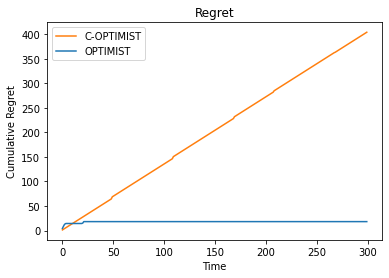

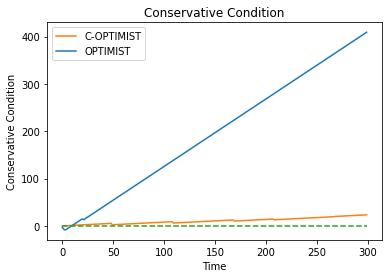

In [ ]:
seed = 21
T = 300
K=5
np.random.seed(seed)
np.set_printoptions(precision=2)

traces1, traces2 = [], []
for _ in range(K):
    #run Conservative OPTIMIST
    env = GridWorldWithPits(P,R)

    #build policies
    arms = []
    for theta in np.arange(-5,5,1):
        arms.append(Arm(env, theta, sigma))

    #play conservative OPTIMIST
    trace, debug = Conservative_Optimistic(T, mu_b, arms, alpha = alpha, delta = delta)
    print("list of pulled arms: \n", trace)
    print("nb of pulls: \n", [arm.count for arm in arms])

    #compute Te
    divs = np.concatenate( debug["divs"], axis=0 )
    ve = np.max(divs)
    Te = 2*ve*np.power( 5.5*(2*np.sqrt(2)+5/3) /((mus[-1]-mu_b)+alpha*mu_b),0.5)*np.log(1/delta)
    print("ve is:", ve, "Te is:", Te)

    #########################################

    #run of OPTIMIST
    np.set_printoptions(precision=2)
    env = GridWorldWithPits(P,R)
    np.random.seed(seed)
    T2 = 55

    #build policies
    env = GridWorldWithPits(P,R)
    arms = []
    for theta in np.arange(-5,5,1):
        arms.append(Arm(env, theta, sigma))

    #play OPTIMIST
    trace2, debug2 = Optimistic(T2, arms, delta = delta)
    print("list of pulled arms: \n", trace2)
    print("nb of pulls: \n", [arm.count for arm in arms])

    #plot regret extended to T
    trace2 = list(np.concatenate((np.array(trace2), trace2[-1]*np.ones(T-T2))))
    trace2 = [e.astype(int) for e in trace2]

    #########################################
    traces1.append(trace)
    traces2.append(trace2)

#plot regret
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
plot_regret(ax, trace, mus, color = "tab:orange")
plot_constraints(ax2, trace, mus, alpha, color = "tab:orange")
plot_regret(ax, trace2, mus, color = "tab:blue")
plot_constraints(ax2, trace2, mus, alpha, color = "tab:blue")
ax2.plot(np.zeros(len(trace)), color = "tab:green", linestyle = "--")
ax.legend(["C-OPTIMIST", "OPTIMIST"])
ax2.legend(["C-OPTIMIST", "OPTIMIST"])
plt.show()

##Plot the dynamic of Conservative Optimistic

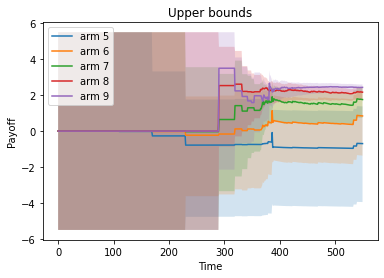

In [ ]:
#plot dynamic of conservative OPTIMIST
fig, ax = plt.subplots()
ubs = np.reshape(np.concatenate( debug["ub"], axis=0 ), (-1,10))
lbs = np.reshape(np.concatenate( debug["lb"], axis=0 ), (-1,10))
mus_bh = np.reshape(np.concatenate( debug["mus_bh"], axis=0 ), (-1,10))
for j in range(5, ubs.shape[1]):
    time = np.arange(mus_bh.shape[0])
    plt.plot(time, mus_bh[:,j])
    plt.fill_between(time, lbs[:,j], ubs[:,j], alpha=0.2)
plt.legend(["arm "+ str(s) for s in range(5, 10)])
plt.title("Upper bounds")
plt.xlabel("Time")
plt.ylabel("Payoff")
plt.show()

##Implementation of CUCBVI

In [ ]:
import numpy as np
import random
import copy
import scipy
from scipy import stats
import sys
import time
import matplotlib.pyplot as plt
import pdb
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class GridWorldWithPits():
    def __init__(self, P, R, H = 10, init_state = 0, randomized = False):
        self.R = R
        self.P = P
        self.H = H
        self.randomized = randomized
        self.init_state = init_state
        self.state_memory = []
        self.reset()
 
    def reward_func(self, state, action):
        return self.R[state, action]
 
    def reset(self):
        self.state = self.init_state
        if self.randomized == True:
            self.state = np.random.randint(0,np.shape(self.P)[0])
        self.state_memory.append(self.state)
        self.t = 0

    def _step(self, action):
        reward = self.R[self.state, action]
        self.state = self.P[self.state, action]
        self.t +=1
        return reward, self.state, (self.t == self.H)
 
    def step(self, policy):
        action = np.random.choice(np.arange(5), p = policy.eval(self.state)).item()
        reward = self.R[self.state, action]
        self.state = self.P[self.state, action]
        self.t +=1
        if self.t == self.H: 
            done = True
        else: done = False
        return reward, done

#define deterministic transitions
P = np.array([[4,1,0,0,0],
     [5,2,1,0,1],
     [6,3,2,1,2],
     [7,3,3,2,3],
     [8,5,0,4,4],
     [9,6,1,4,5],
     [10,7,2,5,6],
     [11,7,3,6,7],
     [8,9,4,8,8],
     [9,10,5,8,9],
     [10,11,6,9,10],
     [11,11,7,10,11]])

#define rewards
R = -0.1*np.ones((12,5))
R[7,0] = 0.5
R[10,1] = 0.5
R[11,4] = 0.5
R[1,0] = -1
R[4,1] = -1
R[9,2] = -1
R[6,3] = -1
R[5,4] = -1

R = MinMaxScaler().fit_transform(R.flatten().reshape(-1,1)).reshape(R.shape)


baseline_policy = np.array([[0,1,0,0,0],
                            [0,1,0,0,0],
                            [0.5,0.5,0,0,0],
                            [1,0,0,0,0],
                            [0,0,1,0,0],
                            [0,1,0,0,0],
                            [1,0,0,0,0],
                            [0.5,0,0,0.5,0],
                            [0,0,1,0,0],
                            [0,0,0,1,0],
                            [0,0.5,0,0.5,0],
                            [0,0,0,0,1]])

In [ ]:
class CUCBVI(object):
    def __init__(self,env,baseline_policy,K,bonus_coef,delta):
        self.env = env
        self.baseline_policy = baseline_policy
        self.K = K
        self.bonus_coef = bonus_coef
        self.delta = delta

        self.buffer = [[] for _ in range(self.K)]
        self.N_sas = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1], np.shape(self.env.P)[0]))
        self.N_sa = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1]))

        self.R = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1]))
        self.P = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1], np.shape(self.env.P)[0]))
        self.Q = np.zeros((self.env.H, np.shape(self.env.P)[0], np.shape(self.env.P)[1]))
        
        
    def update_buffer(self,s,a,r,s_,k):
        self.buffer[k].append((s,a,r,s_))
    
    def act(self,s,h):
        #return np.argmax(self.Q[h,s,:])
        return np.random.choice(np.flatnonzero(self.Q[h,s,:] == self.Q[h,s,:].max()))

    def act_baseline(self,s):
        return np.random.choice(range(self.baseline_policy.shape[1]), p=self.baseline_policy[s])
    
    def learn(self,k):
        self.update_counts_and_rewards(k)
        self.update_probability_transition()
        self.update_value_functions()

    def update_counts_and_rewards(self, k):
        for step in self.buffer[k]:
            s,a,r,s_ = step
            self.R[s,a] = self.R[s,a]*self.N_sa[s,a] + r
            self.N_sas[s,a,s_] += 1
            self.N_sa[s,a] += 1
            self.R[s,a] /= self.N_sa[s,a]
    
    def update_probability_transition(self):
        for s in range(self.env.P.shape[0]):
            for a in range(self.env.P.shape[1]):
                if self.N_sa[s,a] > 0:
                    for s_ in range(self.env.P.shape[0]):
                        self.P[s,a,s_] = self.N_sas[s,a,s_] / self.N_sa[s,a]
    
    def update_value_functions(self):
        V = np.zeros((self.env.H + 1, self.env.P.shape[0]))
        for h in range(self.env.H - 1, -1, -1):
            for s in range(self.env.P.shape[0]):
                for a in range(self.env.P.shape[1]):
                    if self.N_sa[s,a] > 0:
                        self.Q[h,s,a] = min(self.env.H - h, self.R[s,a] + self.bonus(s,a) + np.dot(self.P[s,a,:], V[h+1,:]))
                        #self.Q[h,s,a] = min(min(self.Q[h,s,a], self.env.H), self.R[s,a] + self.bonus(s,a) + np.dot(self.P[s,a,:], V[h+1,:]))
                    else:
                        self.Q[h,s,a] = self.env.H - h
                        #self.Q[h,s,a] = self.env.H
                V[h,s] = min(self.env.H - h, np.max(self.Q[h,s,:]))
                #V[h,s] = np.max(self.Q[h,s,:])

    def compute_pessismistic_estimate(self):
        V = np.zeros((self.env.H + 1, self.env.P.shape[0]))
        for h in range(self.env.H - 1, -1, -1):
            for s in range(self.env.P.shape[0]):
                pol = np.array(self.Q[h,s,:] == self.Q[h,s,:].max(), dtype=int)/np.sum(self.Q[h,s,:] == self.Q[h,s,:].max())
                for a in range(self.env.P.shape[1]):
                    if self.N_sa[s,a] > 0:
                        V[h,s] += pol[a]*(self.R[s,a] - self.bonus(s,a) + np.dot(self.P[s,a,:], V[h+1,:]))
                V[h,s] = max(0, V[h,s])
        return V[0,:]
                   
    def bonus(self,s,a):
        return self.bonus_coef*(self.env.H + 1)*np.sqrt(np.log(self.N_sa[s,a]/self.delta)/self.N_sa[s,a])
        #return self.bonus_coef*(7*self.env.H/np.sqrt(self.N_sa[s,a]))*np.log(5*self.env.P.shape[0]*self.env.P.shape[1]*self.env.H*self.K/self.delta)

    def evaluate_payoff(self, baseline=False):
        cum_reward = 0
        self.env.reset()
        done = False
        while not done:
            s = self.env.state
            h = self.env.t
            if baseline:
                a = self.act_baseline(s)
            else:
                a = self.act(s,h)
            r, s_, done = self.env._step(a)
            cum_reward += r
        return cum_reward

##Runs of CUCBVI

In [ ]:
#random seed for reproducible results
#without_conservative: set to True to run UCB-VI, or False to run CUCB-VI

np.random.seed(0)
without_conservative = False
all_regrets = []
all_budgets = []

for _ in range(5):

    env = GridWorldWithPits(P, R)
    K = 300 #number of episodes
    alpha = 0.1 #conservative alpha parameter
    agent = CUCBVI(env, baseline_policy, K, bonus_coef=0.01, delta=0.1) #bonus coef is the coefficient in front of the count-based bonus term, delta is the confidence parameter

    value_opt_pol = 8.4  #value of the optimal policy starting at initial state 0
    value_baseline_pol = 7.4 #value of the baseline policy starting at initial state 0 (computed by monte-carlo estimates)
    regrets = []
    budgets = [0]
    exec_baseline = False

    for k in range(K):
        env.reset()
        start_state = env.state
        v = agent.compute_pessismistic_estimate()[start_state]
        if without_conservative:
            exec_baseline = False
            budgets.append(budgets[-1] + v - (1-alpha)*value_baseline_pol)
        else:
            if budgets[-1] + v - (1-alpha)*value_baseline_pol >= 0:
                exec_baseline = False
                budgets.append(budgets[-1] + v - (1-alpha)*value_baseline_pol)
            else:
                exec_baseline = True
                budgets.append(budgets[-1] + alpha*value_baseline_pol)
        done = False
        while not done:
            s = env.state
            h = env.t
            if exec_baseline:
                a = agent.act_baseline(s)
            else:
                a = agent.act(s,h)
            r, s_, done = env._step(a)
            agent.update_buffer(s,a,r,s_,k)
        if exec_baseline:
            regrets.append(value_opt_pol - value_baseline_pol)
        else:
            regrets.append(value_opt_pol - agent.evaluate_payoff())
        agent.learn(k)

    all_regrets.append(np.cumsum(regrets))
    all_budgets.append(budgets)

all_regrets = np.array(all_regrets)
all_budgets = np.array(all_budgets)

##Merge regret curves Conservative-Optimisitic and CUCBVI

Text(0.5, 1.0, 'Regret')

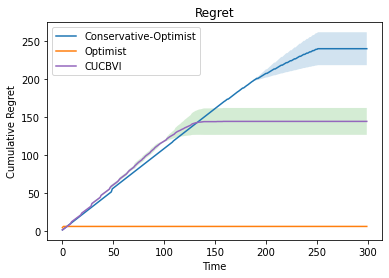

In [ ]:
regrets1 = []
for trace1 in traces1:
    play = 0
    regret = np.zeros(len(trace1))

    for t, e in enumerate(trace1):
        if e == -1: 
            play += mu_b
        else:
            play += mus[e]
        regret[t] = (t+1)*mus[-1] - play
    regrets1.append(regret)

regrets2 = []
for trace2 in traces2:
    play = 0
    regret = np.zeros(len(trace2))

    for t, e in enumerate(trace2):
        if e == -1: 
            play += mu_b
        else:
            play += mus[e]
        regret[t] = (t+1)*mus[-1] - play
    regrets2.append(regret)

regrets1 = np.array(regrets1)
regrets2 = np.array(regrets2)

#Conservative OPTIMIST
mn1 = np.mean(regrets1, axis = 0)
sd1 = np.std(regrets1, axis = 0)

#OPTIMIST
mn2 = np.mean(regrets2, axis = 0)
sd2 = np.std(regrets2, axis = 0)

#CUCBVI
mn3 = np.mean(all_regrets, axis=0)
sd3 = np.std(all_regrets, axis=0)

#plots
plt.plot(mn1, color="tab:blue")
plt.fill_between(np.arange(300), mn1+sd1, mn1-sd1, alpha=0.2)
plt.plot(mn2, color="tab:orange")
plt.fill_between(np.arange(300), mn2+sd2, mn2-sd2, alpha=0.2)
plt.plot(mn3, color="tab:purple")
plt.fill_between(np.arange(300), mn3+sd3, mn3-sd3, alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend(["Conservative-Optimist", "Optimist", "CUCBVI"])
plt.title("Regret")

Plot and merge the conservative condition of CUCBVI & Optimisitc

Text(0.5, 1.0, 'Conservative Condition')

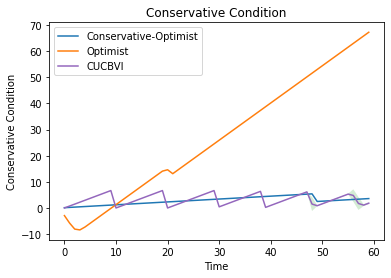

In [ ]:
cut=60

conditions1 = []
for trace1 in traces1:
    cc = np.zeros(len(trace1))
    r = 0
    for t, e in enumerate(trace1):
        if e == -1: 
            play = mu_b
        else:
            play = mus[e]
        r += play - (1-alpha)*mu_b
        cc[t] = r
    conditions1.append(cc)

conditions2 = []
for trace2 in traces2:
    cc = np.zeros(len(trace2))
    r = 0
    for t, e in enumerate(trace2):
        if e == -1: 
            play = mu_b
        else:
            play = mus[e]
        r += play - (1-alpha)*mu_b
        cc[t] = r
    conditions2.append(cc)

#Conservative OPTIMIST
mn1 = np.mean(conditions1, axis = 0)[:cut]
sd1 = np.std(conditions1, axis = 0)[:cut]

#OPTIMIST
mn2 = np.mean(conditions2, axis = 0)[:cut]
sd2 = np.std(conditions2, axis = 0)[:cut]

#CUCBVI
mn3 = np.mean(all_budgets, axis=0)[:cut]
sd3 = np.std(all_budgets, axis=0)[:cut]

#plots
plt.plot(mn1, color="tab:blue")
plt.fill_between(np.arange(cut), mn1+sd1, mn1-sd1, alpha=0.2)
plt.plot(mn2, color="tab:orange")
plt.fill_between(np.arange(cut), mn2+sd2, mn2-sd2, alpha=0.2)
plt.plot(mn3, color="tab:purple")
plt.fill_between(np.arange(cut), mn3+sd3, mn3-sd3, alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Conservative Condition")
plt.legend(["Conservative-Optimist", "Optimist", "CUCBVI"])
plt.title("Conservative Condition")

#Experiment 2: multiple runs for different sigmas

In [ ]:
sigmas = range(1,5)

#experiment setting
np.set_printoptions(precision=2)
env = GridWorldWithPits(P,R)
alpha = 0.1
delta = 0.05
np.random.seed(42)
mu_b = 1.1024240000000003 #1 000 000 runs baseline payoff

mus = np.zeros((len(sigmas), len(np.arange(-5,5,1))))
for i, sigma in enumerate(sigmas):
    print(sigma)
    #build policies
    env = GridWorldWithPits(P,R)
    arms = []
    for theta in np.arange(-5,5,1):
        arms.append(Arm(env, theta, sigma))
    mus[i,:] = evaluate(env, arms, n=1000)

print("arms average payoff: \n", mus)

1
2
3
4
arms average payoff: 
 [[-1.92 -1.89 -1.87 -1.78 -1.32 -0.51  0.68  1.52  2.12  2.42]
 [-1.99 -1.97 -1.88 -1.57 -1.21 -0.35  0.54  1.4   1.97  2.29]
 [-1.95 -1.92 -1.79 -1.49 -1.05 -0.25  0.5   1.24  1.85  2.25]
 [-1.93 -1.86 -1.68 -1.43 -0.89 -0.28  0.56  1.15  1.76  2.15]]


1
50
pulls nb: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mus_hat: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ubs: [5.5 5.5 5.5 5.5 5.5 5.5 5.5 5.5 5.5 5.5]
lbs: [-5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5]


110
pulls nb: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
mus_hat: [-1.90e+00 -1.89e+00 -6.94e-01 -9.37e-02 -4.65e-03 -8.49e-05 -5.70e-07
 -1.41e-09 -1.28e-12 -4.28e-16]
ubs: [0.28 1.7  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5 ]
lbs: [-5.32 -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5 ]


170
pulls nb: [1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
mus_hat: [-1.82e+00 -3.04e+00 -2.88e+00 -1.32e+00 -2.47e-01 -1.75e-02 -4.59e-04
 -4.44e-06 -1.58e-08 -2.07e-11]
ubs: [ 0.34 -0.5  -0.73  2.26  5.5   5.5   5.5   5.5   5.5   5.5 ]
lbs: [-5.21 -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5  -5.5 ]


230
pulls nb: [1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
mus_hat: [-1.79e+00 -3.08e+00 -3.55e+00 -2.77e+00 -1.26e+00 -2.68e-01 -2.31e-02
 -7.55e-04 -9.16e-06 -4.10e-08]
ubs: [ 0.37 -0.54 -1.41 -0.23  0.9   3.32  5.5   5.5   5.5   5.5 ]
lbs: [-

KeyboardInterrupt: ignored

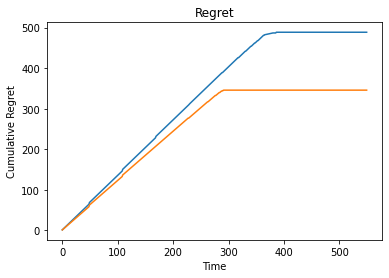

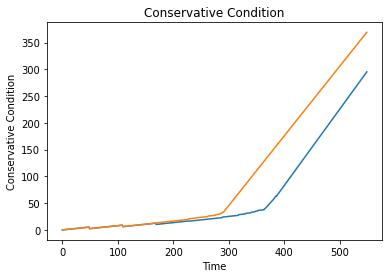

In [ ]:
np.random.seed(42)
T = 550
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

for i, sigma in enumerate(sigmas):
    print(sigma)

    #play conservative
    env = GridWorldWithPits(P,R)
    arms = []
    for theta in np.arange(-5,5,1):
        arms.append(Arm(env, theta, sigma))
    trace, debug = Conservative_Optimistic(T, mu_b, arms, alpha = alpha, delta = delta)
    print("list of pulled arms: \n", trace)
    print("nb of pulls: \n", [arm.count for arm in arms])

    #plot regret
    plot_regret(ax, trace, mus[i,:])
    plot_constraints(ax2, trace, mus[i,:], alpha)

#plot
ax.legend(["sigma=" + str(s) for s in sigmas])
ax2.legend(["sigma=" + str(s) for s in sigmas])
plt.show()

#Experiment 3: Evaluation of Conservative Optimist against CUCBVI conservative condition

In [ ]:
#experiment setting
np.set_printoptions(precision=2)
sigma = 1
alpha = 0.1
delta = 0.05
np.random.seed(42)
arms_list = np.arange(-5,5,1)

#Evaluate every policy on every state
eval = np.zeros((12, len(arms_list)))
n = 10000
for i in range(12):
    env = GridWorldWithPits(P,R, init_state = i)
    arms = []
    for theta in arms_list:
        arms.append(Arm(env, theta, sigma))
    for j, p in enumerate(arms):
        mus = evaluate(env, arms, n=1000)
        eval[i,:] = mus
    print("state: ", i, " done!")
    print("arms average payoff: \n", mus)
print("Evaluation for each state of mu: \n", eval)

#Evaluate baseline policy on every state
baseline = Baseline()
evalb = np.zeros((12,1))
for i in range(env.P.shape[0]):
    env = GridWorldWithPits(P,R, init_state = i)
    for _ in range(1000):
        done, payoff = False, 0
        payoffs = []
        while done != True:
            r, done = env.step(baseline)
            payoff += r
        payoffs.append(payoff)
        env.reset()
    evalb[i,:] = np.mean(payoffs)
print("baseline evaluation for each state: ", evalb)

In [ ]:
#new state
np.random.seed(42)
T = 350
mu_b = 1.8186679999999995 #1 000 000 runs

env = GridWorldWithPits(P,R, randomized = True)
arms = []
for theta in range(-5,5):
    arms.append(Arm(env, theta, sigma))
trace, debug = Conservative_Optimistic(T, mu_b, arms, alpha = alpha, delta = delta)
state_trace = np.zeros(T)
j=0
for t in range(T):
    if trace[t] == -1:
        state_trace[t] = -1
    else:
        state_trace[t] = env.state_memory[j]
        j+=1

r = 0
res = np.zeros(T)
for t in range(T):
    if trace[t] == -1:
        pass
    else:
        y = trace[t]
        x = int(state_trace[t])
        r += eval[x,y] - (1-alpha)*evalb[x]
    res[t] = r

plt.plot(res)
plt.plot(np.zeros(len(res)), "k", linestyle = ":")
plt.xlabel("Time")
plt.ylabel("Conservative Condition ")
plt.title("Conservative Exploration conditionned on initial state")
plt.legend(["C-OPTIMIST"])
plt.show()